# Erebus VCA filter

## Import Libraries

In [2]:
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import inv
import math

## Generate Waveform

In [3]:
# user variables
wave_freq = 100.0 #Hz
cycles = 5
samplerate = 48000

# conversions / calculations
duration = cycles / wave_freq #sec
duration_ms = duration * 1000.0 #msec
lengthInSamps = math.ceil(duration * samplerate)

# create time axis
time = np.linspace(0, duration, lengthInSamps)

# choose a waveform
#wave = signal.sawtooth(2.0*np.pi*wave_freq*time)
wave = signal.square(2.0*np.pi*wave_freq*time, duty=(2.0*np.pi*time + 1)/2)

## Calculate Filter

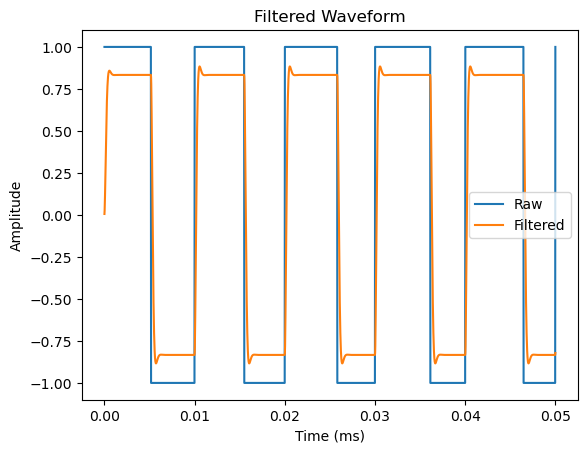

Maximum iterations: 2


In [4]:
# filter parameters
input_gain = 1.5
cutoff = 1000.0
r = 0.8 # resonance (0.0 to 4.0)

g = np.tan(cutoff * np.pi / samplerate)
boosted_wave = wave * input_gain

# initial values
y = np.array([0.0, 0.0])  # inital guess
errorThresh = 0.000001 # max NR error (stopping condition)
maxIter = 0
filtered_wave = np.zeros(len(boosted_wave))

# state values (initially zero)
s1 = 0.0
s2 = 0.0


# NR loop
for n in range(len(boosted_wave)):
    # input (current sample)
    x = boosted_wave[n]
    
    i = 0
    residue = 100 # something large
    while(abs(residue) > errorThresh and i < 50):

        # F(y) using current y values
        y1 = g*(x - y[0] - r*y[1]) + s1 - y[0]
        y2 = g*(y[0] - y[1]) + s2 - y[1]
        F = np.array([y1, y2]).T

        # Jacobian Matrix
        J = np.array([
            [-g-1.0, -g*r],
            [g, -g-1.0]])


        # calculate next NR step
        y_est = y
        y = y - np.matmul(inv(J), F)
        residue = y[1] - y_est[1] # only care about y4 residue
        i = i + 1
    
    # save y
    filtered_wave[n] = y[1]
    
    # update states
    s1 = 2.0 * y[0] - s1
    s2 = 2.0 * y[1] - s2
    
    # log max iterations
    if i > maxIter:
        maxIter = i
    
# plot waveform 
plt.plot(time, wave, label="Raw")
plt.plot(time, filtered_wave, label="Filtered")
plt.xlabel("Time (ms)")
plt.ylabel("Amplitude")
plt.title("Filtered Waveform")
plt.legend()
plt.show()

# print max iterations
print("Maximum iterations: " + str(maxIter))


## Direct Matrix Solver

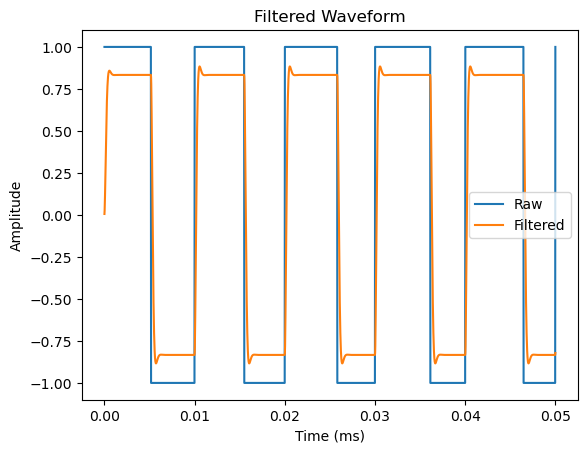

Maximum iterations: 1


In [5]:
# filter parameters
input_gain = 1.5
cutoff = 1000.0
r = 0.8 # resonance (0.0 to 4.0)

g = np.tan(cutoff * np.pi / samplerate)
boosted_wave = wave * input_gain

# initial values
y = np.array([0.0, 0.0])  # inital guess
errorThresh = 0.000001 # max NR error (stopping condition)
maxIter = 0
filtered_wave = np.zeros(len(boosted_wave))

# state values (initially zero)
s1 = 0.0
s2 = 0.0


# NR loop
for n in range(len(boosted_wave)):
    # input (current sample)
    x = boosted_wave[n]
    
    i = 0
    residue = 100 # something large
    while(abs(residue) > errorThresh and i < 50):

        # F(y) using current y values
        y1 = g*(x - y[0] - r*y[1]) + s1 - y[0]
        y2 = g*(y[0] - y[1]) + s2 - y[1]
        F = np.array([y1, y2]).T

        # Jacobian Matrix Elements
        j_help = -1.0*(g + 1.0) # used twice
        j00 = j_help
        j01 = -g*r
        j10 = g
        j11 = j_help
        jdem = j00*j11 - j01*j10


        # calculate next NR step
        y_est = y
        
        
        y[0] = y[0] + (F[1]*j01 - F[0]*j11) / jdem
        y[1] = y[1] + (F[0]*j10 - F[1]*j00) / jdem
        
        
        residue = y[1] - y_est[1] # only care about y2 residue
        i = i + 1
    
    # save y
    filtered_wave[n] = y[1]
    
    # update states
    s1 = 2.0 * y[0] - s1
    s2 = 2.0 * y[1] - s2
    
    # log max iterations
    if i > maxIter:
        maxIter = i
    
# plot waveform 
plt.plot(time, wave, label="Raw")
plt.plot(time, filtered_wave, label="Filtered")
plt.xlabel("Time (ms)")
plt.ylabel("Amplitude")
plt.title("Filtered Waveform")
plt.legend()
plt.show()

# print max iterations
print("Maximum iterations: " + str(maxIter))